In [211]:
def FASTAReader(file):
    # Get the first line, which should contain the sequence name
    line = file.readline()

    # Let's make sure the file looks like a FASTA file
    assert line.startswith('>'), "Not a FASTA file"
    
    # Get the sequence name
    seq_id = line[1:].rstrip('\r\n')

    # create a list to contain the 
    sequence = []

    # Get the next line
    line = file.readline()

    # Add a list to hold all of the sequences in
    sequences = []

    # Keep reading lines until we run out
    while line:
        # Check if we've reached a new sequence (in a multi-sequence file)
        if line.startswith('>'):
            # Add previous sequence to list
            sequences.append((seq_id, ''.join(sequence)))
            
            # Record new sequence name and reset sequence
            seq_id = line[1:].rstrip('\r\n')
            sequence = []
        else:
            # Add next chunk of sequence
            sequence.append(line.strip())
        
        # Get the next line
        line = file.readline()
    # Add the last sequence to sequences
    sequences.append((seq_id, ''.join(sequence)))

    return sequences

In [212]:
mafft_output = FASTAReader(open('mafft_out.fa'))
query_and_blast = FASTAReader(open('query_and_blast_out.fa'))
# Query is in index zero
query_align = mafft_output[0]
query_nt = query_and_blast[0]

In [213]:
len(query_nt[1])

10293

In [214]:
query_aa = query_align[1]
#print(query_aa)

In [215]:
# Check length of alignment sequences
# for seq in query_and_blast:
#     print(len(seq[1]))

In [216]:
print(len(query_align[1]))

6121


In [292]:
# Initialize empty list for query and initialize counter
query_seqs = []
counter = 0

for line in query_align[1]:
    if (line == '-'):
        query_seqs.append("---")
    else:
        query_seqs.append(query_nt[1][counter:counter+3])
        counter += 3 

# DNA converted from protein alignment
query_seqs = ("".join(query_seqs))

In [291]:
# Check length
print(len(query_seqs))

18363


In [290]:
# Initialize empty list for alignment nucleotide sequences
nt_seqs = []

# Iterate in parallel through amino acids and nucleotides of alignments
for aa_seq, nt_seq in zip(mafft_output[1:], query_and_blast[1:]):
    # Initialize counter and temporary list
    counter = 0
    new_nt_seq = []
    
    for aa in aa_seq[1]: 
        # Replace dash with three
        if (aa == '-'):
            new_nt_seq.append("---")
        # Append nucleotide sequence guided by protein sequence
        else:
            new_nt_seq.append(nt_seq[1][counter:counter+3])
            counter += 3 
        
    nt_seqs.append("".join(new_nt_seq))

In [289]:
# Check nt length of alignments
# for seq in nt_seqs:
#     print(len(seq))

In [287]:
# Break query into codons
n = 3 
query_codons = [query_seqs[i:i+n] for i in range(0, len(query_seqs), n)]

In [286]:
# Check length
len(query_codons)

6121

In [228]:
# Break alignment into codons
n = 3
all_align_codons = []

for seq in nt_seqs:
    align_codons = []
    for i in range(0, len(seq), n):
        align_codons.append(seq[i:i+n])
    # Append to nested list for each sequence 
    all_align_codons.append(align_codons)

In [283]:
# Check length
len(all_align_codons)

1000

In [285]:
# Check length of alignment sequences
# for seq in all_align_codons:
#     print(len(seq))

In [232]:
codontable = {
'ATA':'I', 'ATC':'I', 'ATT':'I', 'ATG':'M',
'ACA':'T', 'ACC':'T', 'ACG':'T', 'ACT':'T',
'AAC':'N', 'AAT':'N', 'AAA':'K', 'AAG':'K',
'AGC':'S', 'AGT':'S', 'AGA':'R', 'AGG':'R',
'CTA':'L', 'CTC':'L', 'CTG':'L', 'CTT':'L',
'CCA':'P', 'CCC':'P', 'CCG':'P', 'CCT':'P',
'CAC':'H', 'CAT':'H', 'CAA':'Q', 'CAG':'Q',
'CGA':'R', 'CGC':'R', 'CGG':'R', 'CGT':'R',
'GTA':'V', 'GTC':'V', 'GTG':'V', 'GTT':'V',
'GCA':'A', 'GCC':'A', 'GCG':'A', 'GCT':'A',
'GAC':'D', 'GAT':'D', 'GAA':'E', 'GAG':'E',
'GGA':'G', 'GGC':'G', 'GGG':'G', 'GGT':'G',
'TCA':'S', 'TCC':'S', 'TCG':'S', 'TCT':'S',
'TTC':'F', 'TTT':'F', 'TTA':'L', 'TTG':'L',
'TAC':'Y', 'TAT':'Y', 'TAA':'_', 'TAG':'_',
'TGC':'C', 'TGT':'C', 'TGA':'_', 'TGG':'W'
}

In [281]:
# Initialize synonymous and nonsynonymous lists
syn_list = []
nonsyn_list = []

# Move to nested list 
for idx, val in enumerate(all_align_codons):
    # Initialize temporary lists to hold synonymous and nonsynonymous
    synonymous = []
    nonsynonymous = []
    # Iterate through codons in each alignment in parallel with query
    for (codon_a, codon_q) in zip(val, query_codons):
        # If alignment codon is gap and query codon is not, add zero to both lists because query codon is what we will be plotting
        if codon_a == '---' and codon_q != '---':
            synonymous.append(0)
            nonsynonymous.append(0)
            # Next iteration
            continue
        # If alignment codon is not gap but query codon is, skip
        if codon_a != '---' and codon_q == '---':
            # Next iteration
            continue
        # If both are gaps, skip
        if codon_a == '---' and codon_q == '---':
            # Next iteration
            continue
        # If codons are the same, append zero to both lists
        if (codon_a == codon_q):
            synonymous.append(0)
            nonsynonymous.append(0)
            # Next iteration
            continue
        # Account for NNN and codons like YTG
        if codon_a not in codontable:
            synonymous.append(0)
            nonsynonymous.append(0)
            # Next iteration
            continue
        # If alignment codon is in the table
        if codon_a in codontable:
            # Amino acids are not equal, i.e. nonsynonymous mutation
            if (codontable[codon_q] != codontable[codon_a]):
                # Append 1 to nonsynonymous, 0 to synonymous
                nonsynonymous.append(1)
                synonymous.append(0)
            # Amino acids are equal, i.e. synonymous mutation
            if (codontable[codon_q] == codontable[codon_a]):
                # Append 1 to synonymous, 0 to nonsynonymous
                synonymous.append(1)
                nonsynonymous.append(0)
    # Append lists to permanent list
    syn_list.append(synonymous)
    nonsyn_list.append(nonsynonymous)

In [237]:
len(syn_list)

1000

In [238]:
len(nonsyn_list)

1000

In [280]:
# Check length of each aligned sequence
# for seq in syn_list:
#     print(len(seq))

In [240]:
# Sum the nested lists in each list
N_sum = [sum(x) for x in zip(*nonsyn_list)]
S_sum = [sum(x) for x in zip(*syn_list)]

In [241]:
# Check length
len(N_sum)

3430

In [279]:
# Calculate difference between dN and dS
difference = [x-y for x,y in zip(N_sum, S_sum)]

In [278]:
from scipy import stats
# Calculate standard deviation of differences
std = stats.tstd(difference)
std

223.0623054910906

In [277]:
# Convert list of differences to dataframe
stats = pd.DataFrame(difference, columns = ['difference'])
stats

,difference
0,870
1,40
2,853
3,419
4,786
...,...
3425,709
3426,709
3427,604
3428,587


In [276]:
# Calculate Z-score
stats['zscore'] = ((0 - stats['difference'])/std)
stats

,difference,zscore
0,870,-3.900256
1,40,-0.179322
2,853,-3.824044
3,419,-1.878399
4,786,-3.523679
...,...,...
3425,709,-3.178484
3426,709,-3.178484
3427,604,-2.707764
3428,587,-2.631552


In [246]:
# Check length
len(difference)

3430

In [247]:
# Divide the lists
# If y is zero, make value zero to avoid error
dN_dS = [x/y if y else 0 for x,y in zip(N_sum, S_sum)]

In [249]:
import numpy as np
# Take log2 of ratio, if x is zero make value zero to avoid error
log_dN_dS = [np.log2(x) if x else 0 for x in dN_dS]

In [1]:
#log_dN_dS

In [251]:
# Check length, should be same as number of codons
len(log_dN_dS)

3430

In [275]:
# Convert list to array
log_dN_dS_arr = np.array(log_dN_dS)

In [253]:
import pandas as pd
# Convert array to dataframe
df = pd.DataFrame(log_dN_dS_arr)
df

,0
0,0.000000
1,0.144390
2,0.000000
3,1.685685
4,7.625709
...,...
3425,8.473706
3426,8.473706
3427,2.709574
3428,2.589067


In [254]:
# rename column for plotting
df = df.rename(columns={0:'log2ratio'})

In [274]:
# Convert to float (don't know if this was really necessary, I just did it)
df['log2ratio'] = df['log2ratio'].astype(float)

In [273]:
# Merge statistics dataframe and log2 ratio dataframe
df2 = pd.merge(df, stats, right_index=True, left_index=True)

In [272]:
# Number of significant nonsynonymous mutations
len(df2[(df2['zscore'] <= -1.96)])

3078

In [271]:
# Assign index to column for plotting codon position
df2['x1'] = df2.index

In [260]:
df2

,log2ratio,difference,zscore,x1
0,0.000000,870,-3.900256,0
1,0.144390,40,-0.179322,1
2,0.000000,853,-3.824044,2
3,1.685685,419,-1.878399,3
4,7.625709,786,-3.523679,4
...,...,...,...,...
3425,8.473706,709,-3.178484,3425
3426,8.473706,709,-3.178484,3426
3427,2.709574,604,-2.707764,3427
3428,2.589067,587,-2.631552,3428


In [270]:
# remove zeroes from dataframe so they are not plotted
df2.replace(0, np.nan, inplace=True)

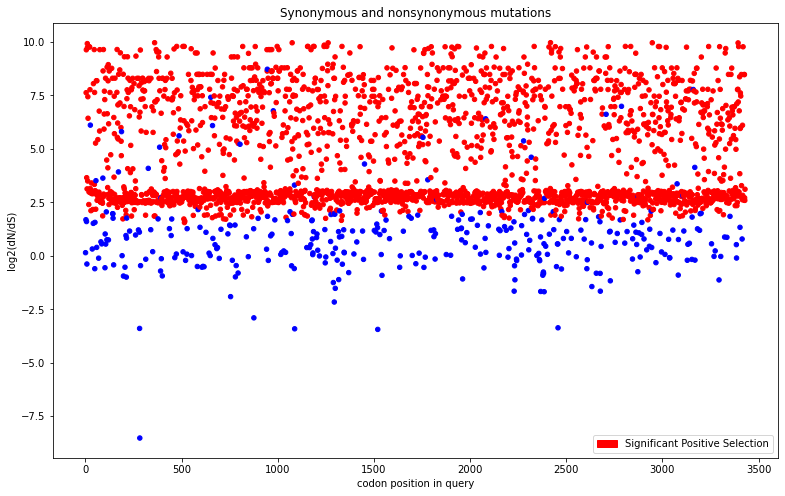

In [269]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

colors = np.where(((df2['zscore']<=(-1.96)) & (df2['log2ratio'] > 0)), 'r','b')
red_label = mpatches.Patch(color='red',label='Significant Positive Selection')

df2.plot(kind='scatter', x='x1', y='log2ratio', c=colors)
fig = plt.gcf()
fig.set_size_inches(13,8)
plt.title('Synonymous and nonsynonymous mutations')
plt.ylabel('log2(dN/dS)')
plt.xlabel('codon position in query')
plt.tight_layout
plt.legend(handles=[red_label])

plt.show()

- If dN/dS > 1, log2 > 0
- If dN/dS < 1, log2 < 0 
- Graph shows more nonsynonymous than synonymous changes, and most nonsynonymous are significant (red = significant)